### **3. 方法**

在本节中，我们首先描述3MT的整体架构设计。然后，我们将详细解释不同的模态嵌入、模态聚合、使用模态丢弃处理缺失数据以及用于平衡训练信号的辅助输出。接下来，我们列出实现细节和数据预处理步骤。



#### **3.1. 架构概述**

如图1所示，3MT的架构设计是一个序列，其中每个模态转换器都结合了来自特定模态的特征，最后，通过聚合提取的多模态特征，可以获得更准确的类别预测。在这种情况下，类别预测从一个学习到的查询向量 $\mathbf{Q_L}$（512维）开始，然后通过一系列CMT（模态转换器），注入多模态信息，最终得到输出AD/CN或进行性MCI（pMCI）/稳定MCI（sMCI）。每个CMT使用交叉注意力来将指定的模态注入 $\mathbf{Q_L}$。在通过CMT注入之前，每个模态都从其原始数据类型转换为向量嵌入 $e$（模态嵌入）。在缺失数据的情况下，对应的CMT接收由MDrops控制的零嵌入，以一定的概率进行注入，这向模型表示“不可用”。通过这种方式，模型在训练时就具备了处理所有缺失数据情况的先验知识。在3MT进行分类或预测时，模态或CMT的数量没有理论限制。


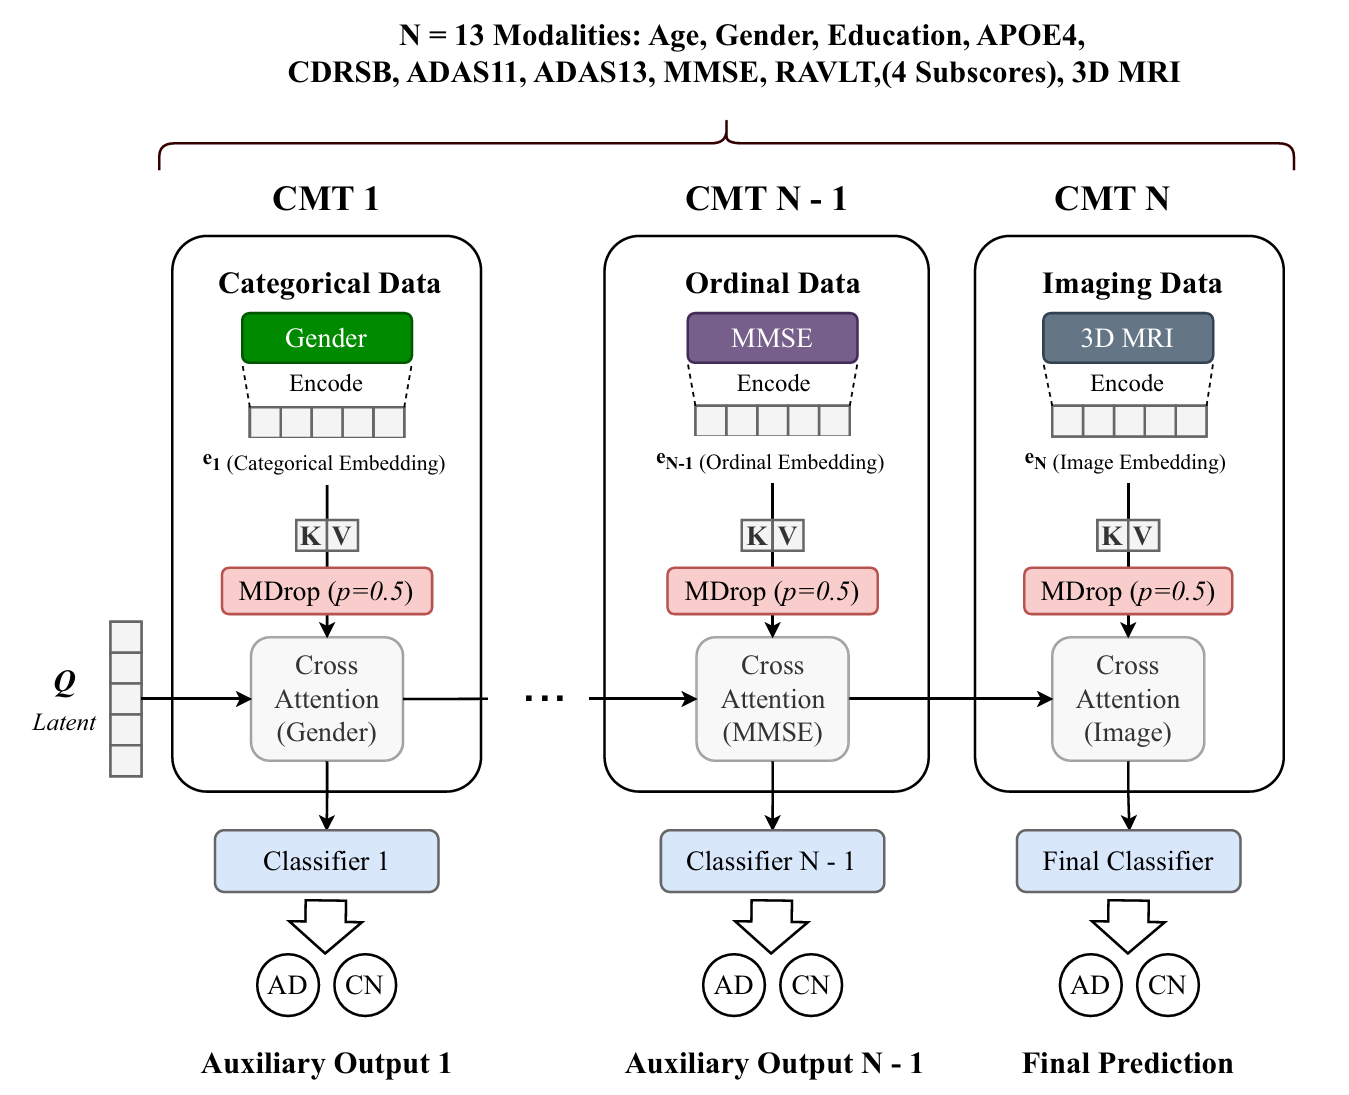

---

**图1. 3MT的网络架构。** 该网络以一个学习到的潜在查询向量 $Q$ 为起点。$N$ 个多模态数据通过 $N$ 个CMT（多模态转换器）注入模型。在每个CMT中，输入数据首先被编码为键向量 $K$ 和值向量 $V$，然后，$K$ 和 $V$ 向量通过交叉注意力机制注入到 $Q$ 中。根据数据类型，不同模态的数据被不同地编码。在所有多模态数据被注入后，生成一个类别预测。

---


#### **3.2. 模态嵌入**

本文使用了以下三种嵌入技术来编码三种类型的输入：
1. **分类嵌入**：通过查找表学习从原始输入到向量嵌入的映射。1维输入进入嵌入层，输出是512维的嵌入特征，以匹配转换器的维度。这种嵌入适用于非序数或分类数据，如性别和载脂蛋白（APOE）4基因分型。
2. **序数嵌入**：通过全连接层学习将原始输入线性变换为向量。输入也是一个1维向量，经过线性变换后输出为512维向量。适用于序数输入，其中顺序具有重要意义，如年龄和认知测试分数。
3. **图像嵌入**：基于CNN-转换器学习的图像特征提取器，可以高效地提取局部AD相关特征和全局长距离空间特征。图像特征提取器的细节如图2所示。图像特征提取器包含四个CNN块，连续下采样3D输入图像以提取与AD相关的3D表示特征。来自最后一个CNN块的特征图被视为输入的补丁表示，意味着特征图中的每个体素代表图像空间中的大面积区域。然后，这些补丁被嵌入到一个位置嵌入层，以在输入到转换器编码器之前保留3D空间信息，从而学习补丁之间的相关性。最后，使用全局平均池化层和线性投影层将转换器的输出减少到512维向量，以便将成像特征注入到交叉注意力模块中，以更新学习到的输入查询。在序列的最后一个CMT的末尾，使用一个分类器（浅层密集连接神经网络）将变换后的 $\mathbf{Q}$ 映射到两个逻辑值，分别表示AD和CN。



#### **3.3. 使用CMT进行模态注入**

CMT是一个序列的转换器解码器块，它接受来自前一个模态转换器的输出或来自 $\mathbf{Q_L}$（如果它是序列中的第一个CMT）的查询输入 $\mathbf{Q_{in}}$，并交叉关注提取的多模态特征，以迭代地用更多信息更新学习到的查询。CMT由多头自注意力层和多头交叉注意力层组成。详细信息如图3所示。在多头自注意力层中，查询、键和值可以定义为 $\mathbf{Q}$、$\mathbf{K}$ 和 $\mathbf{V}$。将它们应用 $h$ 次以执行可学习的线性投影。然后，自注意力点积矩阵（Vaswani等人，2017）可以定义为：

$$\mathsf{Attention}(\mathbf{Q},\mathbf{K},\mathbf{V})=\mathsf{softmax}\left(\frac{\mathbf{Q}\mathbf{K}^{T}}{\sqrt{d_{k}}}\right)\mathsf{V}$$

（1）

所有头连接在一起可以计算为：
$$\mathrm{head}_i=\mathrm{Attention}\Big(\mathbf{QW}_i^Q,\mathbf{KW}_i^K,\mathbf{V}_i^V\Big),$$

（2）

MultiHead($\mathbf{Q},\mathbf{K},\mathbf{V})=\text{concat}(\text{head}_1,\ldots,\text{head}_h)\mathbf{W}^O$,

（3）

其中 $d_k=512$ 且 $h=8$。交叉注意力层与自注意力层类似，不同的是交叉注意力计算输入类之间的注意力，而不是计算自身的注意力。模态嵌入 $e$ 通过交叉注意力注入到 $\mathbf{Q_{in}}$，使用其键 $K$ 和值 $V$。由于转换器在整个过程中保持查询的形状，因此可以级联多个CMT，将混合的多模态信息注入到初始查询中。使用CMT确保每个输入模态与一个CMT匹配，最终输出是看到所有输入后的精炼结果。通过这种设计，即使存在缺失模态，模型仍然可以根据可用模态工作。



#### **3.4. 训练期间的模态丢弃**

为了在训练期间明确模拟各种缺失数据情况，我们提出了一个新颖的MDrop模块，在每个CMT中以概率 $p_{mdrop}$ 随机将对应的模态嵌入置零。$p_{mdrop}$ 的值是可以为每个模态设置的参数。


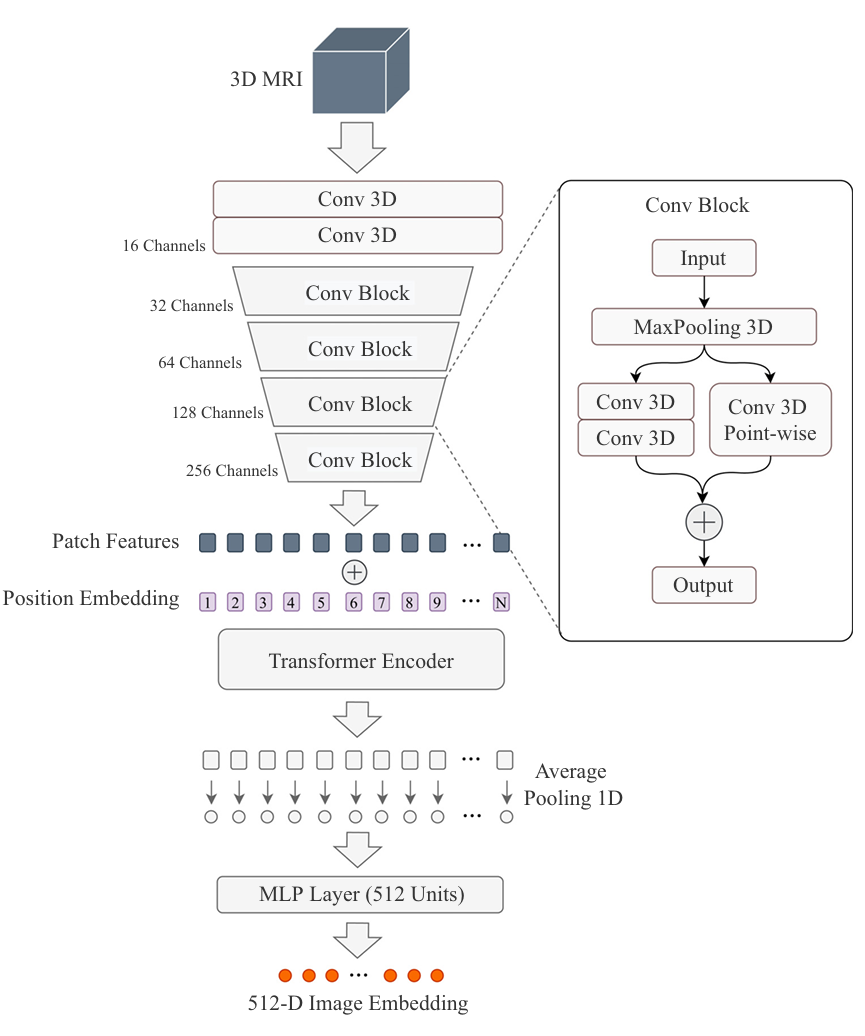

---

**图2**. 用于编码3D图像的CNN转换器的细节。它以两个初始卷积层开始，然后是4个残差CNN下采样块。然后，使用转换器编码器进一步学习补丁相关性。转换器的输出使用补丁级的1D平均池化，然后通过一个线性投影层投影到512维向量。

---

基础与默认值是0.5。根据缺失数据情况的严重程度，𝑝𝑚𝑑𝑟𝑜𝑝的值可能会有所不同。MDrop模块的动机是在训练期间动态模拟缺失数据场景，使模型能够对缺失数据有先验知识，并学会使用剩余的模态更加自适应。

#### 3.5. 用于平衡学习信号的辅助输出
CMT的序列安排可能会导致训练不平衡，因为梯度难以流向较早的CMT。为了应对这个问题，我们在每个CMT的输出上添加了一个辅助分类器，以确保模态的平等贡献。这个想法受到GoogLeNet（Szegedy等人，2015）的启发，它有连接到中间层的辅助输出，用于对输入图像进行分类。而在我们的情况下，辅助输出是在添加模态后添加的，以给出一个中间输出，其损失将添加到最终损失中。在推理时间，这些辅助输出将被丢弃。每个分类器由两个密集连接的层组成，输入和输出分别为512维和2个输出神经元。第一个密集连接层之后有一个LeakyReLu激活函数。分类器之间没有权重共享。
